In [2]:
import numpy as np 
import torch 
import torch.nn as nn 
from torch.optim import SGD 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
import torchvision 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

# Training on MNIST dataset

We will train a simple neural network on the MNIST dataset. The MNIST dataset contains images of handwritten digits. The goal is to train a model to correctly identify the digit (between 0 and 9) written in an image. The MNIST dataset is a classic dataset in machine learning and deep learning, and often used as the "Hello World" of deep learning. 
<p align="center">
    <a href= www.di.ens.fr/~lelarge/MNIST.tar.gz >SOURCE</
</p>

In [3]:
x, y = torch.load('Data/processed/training.pt')

Let's see what kind of data we are dealing with, first.

In [9]:
x.shape, y.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

Just by taking a look at the tensors' shape, it's plausible that the images are 28x28 pixels and there's a total of 60,000 images of that size in $x$, with $y$ being the corresponding digits, stored as a 1D array.

Let's plot any image using the `imshow` function from `matplotlib`.

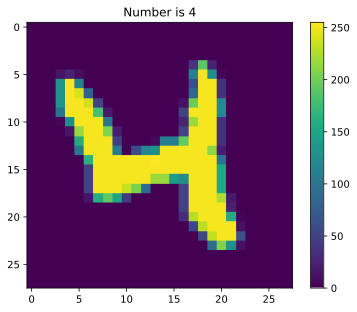

In [12]:
N = 20
plt.imshow(x[N].numpy())
plt.title(f'Number is {y[N].numpy()}')
#plt.grid()
plt.colorbar()
plt.show()

# The One Hot Encoder

The one hot encoder is a very useful tool in machine learning. It is used to convert categorical data into a format that could be provided to ML algorithms to do a better job in prediction. 

Let's say we have the original digits, stored in the array $y$ as integers. 

In [13]:
y_raw = torch.tensor([2, 4, 0, 1, 9, 3])
y_raw

tensor([2, 4, 0, 1, 9, 3])

The fact that the digits are intuitively ordered by their magnitude (0 is smaller than 1, which is smaller than 2, etc.) is not relevant nor useful for the model. Encoding them ensures that they're treated as independent **classes**. 

In [14]:
y_new = F.one_hot(y_raw)
y_new

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

Notice how the encoder returns a 2D tensor, with as many rows as there are samples in $y$ and as many columns as there are possible discrete values in $y$ (knowing that $y$ is a 1D array of integers, the number of possible values is 10, since the digits are between 0 and 9).

The encoder itself takes care of their relative ordering, by placing a 1 in the column corresponding to the digit's value, and 0s everywhere else. 

The machine learning algorithm will then treat each entry as an independent class, regardless of their relative ordering.

Let's now do this for our dataset.

In [15]:
y_encoded = F.one_hot(y, num_classes=10) # this is just explicitly passing how many total univocal classes are present
y_encoded.shape

torch.Size([60000, 10])

## Issues with the Images

Remember the shape of the image data in $x$? It's a 3D tensor, with the first dimension being the number of samples, the second and third dimensions being the height and width of the image, respectively. 

In order to use our **sequential neural network** we need to flatten the images, so that they're 60000 instances of 1D vectors. 

Our model was defined as follows:

$$ \textcolor{green}{\boxed{f(x) = \displaystyle {\Huge{\kappa}}_{i=1}^n R_i (A_i \cdot x + b_i)}}$$

in its most general form.

Remember that $A_i$ are matrices, ${\Huge{\kappa}}$ is a function chaining operator, $b_i$ are bias vectors and $R_i$ is an activation function 
like the **ReLU** (rectified linear unit), for all layers $i$ except the last one, where $R_i$ is the identity function. 

Basically, $R$ has generally this form: 

$$ R(x) = \begin{cases} x & \text{if } x > 0 \\ 0 & \text{otherwise} \end{cases}$$

Which means it's a linear operator only for the positive values of $x$, whereas it introduces a non-linearity by clamping the negative values to 0.

How do we flatten the images? We can use the `view` method of the tensor, which allows us to reshape the tensor, by flattening each image's height and width into a single dimension of length $ h \times w $. 

In [16]:
x.shape, x.view(-1, 28**2).shape

(torch.Size([60000, 28, 28]), torch.Size([60000, 784]))

## PyTorch Dataset Object

PyTorch provides a very useful class called `Dataset`, which is an abstract class representing a dataset, that we can conveniently use to define our own dataset classes.

Let's take advantage of this to create a class that will handle our dataset. We will inherit from the `Dataset` class and our key points will be: 

+ We will redefine the `__len__` method, which will return the size of the dataset, i.e. the number of samples in this case
+ We will redefine the `__getitem__` method, which will return the $i$-th sample of the dataset, where $i$ is the index of the sample
+ We will normalize the images by dividing them by 255 (the maximum value of a pixel for an 8-bit image), as it's a good practice to normalize independent variables in machine learning 
+ We will let the class itself handle the *one hot encoding* of the labels (digits) 
+ We will let the class itself handle the *flattening* of the images' height and width

In [48]:
class MNIST_Dataset(Dataset): 
    def __init__(self, path, bitdepth) -> None:
        super().__init__()
        self.x, self.y = torch.load(path)
        self.x = self.x/(2**bitdepth - 1)
        self.y = F.one_hot(self.y, num_classes=10).to(float)
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [49]:
training_ds = MNIST_Dataset('Data/processed/training.pt', bitdepth=8)
test_ds = MNIST_Dataset('Data/processed/test.pt', bitdepth=8)

In [50]:
len(training_ds) # notice how we redefined a general python method and its modified use on our class is confined within the class itself 

60000

In [55]:
xs, ys = training_ds[0:3] # as a result of redefining the getitem method we can index and slice directly on our class
xs.shape, ys.shape, ys

(torch.Size([3, 28, 28]),
 torch.Size([3, 10]),
 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=torch.float64))

## PyTorch DataLoader Object 

We can put any instance of our `MNISTDataset` class into a `DataLoader` object, which will handle the batching of the data, and the shuffling of the data at each epoch. 

We can directly specify the batch size and the number of workers (threads) to use for the data loading. 

In [60]:
training_dl = DataLoader(training_ds, batch_size=10)

In [61]:
for x, y in training_dl: 
    print(x.shape)
    print(y.shape)
    break 

torch.Size([10, 28, 28])
torch.Size([10, 10])


Let's check the length of the dataloader instance, given that we know there are 60,000 samples in the dataset with a batch size of 10.

In [62]:
len(training_dl)

6000

It returns the number of batches, which is 6000, as expected.

## Cross Entropy Loss

We will use the cross entropy loss, which is seen in depth in the [this notebook](https://github.com/BaldPolnareff/python/blob/main/Notebooks/PyTorch_introduction/Cross-Entropy_loss_function.ipynb). 

To recap, the cross entropy loss is defined as follows: 

$$ \boxed{\displaystyle L(\vec{P}, \vec{Q}) \equiv \sum_{k=1}^N H(\vec{p_{k}}, \vec{q_{k}}) = -\sum_{k=1}^N \ln(\vec{q_{k}}(\tilde{c}(k)))} $$

where $p_k$ is the true class of the $k$-th image and $q_k$ is the predicted class of the $k$-th image.

Fortunately, PyTorch provides a function that implements the cross entropy loss, which we can use directly.

In [63]:
L = nn.CrossEntropyLoss()

## The Neural Network Model 

We will use the 3-layer **sequential neural network** we defined in the [previous notebook](https://github.com/BaldPolnareff/python/blob/main/Notebooks/PyTorch_introduction/sequential_network.ipynb), with some tweaks.

In [71]:
class M3_ReLU_biased_network(nn.Module):
    def __init__(self, width, height) -> None:
        super().__init__()
        self.Matrix1 = nn.Linear(width * height, 100, bias=True)
        self.Matrix2 = nn.Linear(100, 50, bias=True)
        self.Matrix3 = nn.Linear(50, 10, bias=True)
        self.R = nn.ReLU()
    def forward(self, x_batch, width, height): 
        x = x_batch.view(-1, width * height)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()

In [78]:
fun = M3_ReLU_biased_network(28, 28) # creating an instance of the network

Let's take a look at the predictions for the first elements defined in `xs` and `ys` before training.

In [81]:
yhat_test = fun(xs, width=28, height=28)
yhat_test, yhat_test.shape

(tensor([[-0.1097, -0.0116, -0.0953,  0.0091,  0.0795,  0.0134,  0.0854,  0.0591,
           0.1424, -0.0326],
         [-0.1079, -0.0311, -0.1371,  0.0036,  0.0681,  0.0591,  0.0900,  0.0568,
           0.1139,  0.0093],
         [-0.0739, -0.0197, -0.1128,  0.0303,  0.1180,  0.0595,  0.0848,  0.0246,
           0.1423,  0.0064]], grad_fn=<SqueezeBackward0>),
 torch.Size([3, 10]))

These values should be tuned to get to:

In [82]:
ys

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=torch.float64)

Remember that we defined a loss function using the cross entropy loss, let's check the loss before training.

In [83]:
L(yhat_test, ys)

tensor(2.3152, dtype=torch.float64, grad_fn=<DivBackward1>)

We need to minimize this by training the network!

## Training the Network 

We will reimplement the training function from the previous example, with some adaptations.

In [87]:
def train_model(dataloader, network_instance, n_epochs, learning_rate): 
    lr = learning_rate
    dl = dataloader
    f = network_instance

    # Optimization 
    opt = SGD(f.parameters(), lr)
    L = nn.CrossEntropyLoss()

    # Train model 
    losses = []
    epochs = []
    for epoch in range(n_epochs): 
        print(f'Epoch {epoch}')
        N = len(dl) # batch size
        for i, (x, y) in enumerate(dl): 
            # Update the weights of the network
            opt.zero_grad() # flush the gradient or it would cumulate
            loss_value = L(f(x, 28, 28), y) 
            loss_value.backward() # compute gradient 
            opt.step() # use the gradient above to perform the iteration 
            # Store training data 
            epochs.append(epoch + (i/N)) 
            losses.append(loss_value.item())
    return np.array(epochs), np.array(losses)

Let's train for 20 epochs.

In [88]:
training_dl = DataLoader(training_ds, batch_size=5)
epoch_data, loss_data = train_model(training_dl, fun, n_epochs=20, learning_rate=0.01)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


As you can see it took a while but that's normal with the dataset we're using and the network we're training. Also, this has been computed on a CPU, a GPU would have made the training much faster.

Let's now plot the loss function for each batch of $x$ and $y$ throughout the training procedure.

Text(0.5, 1.0, 'Cross Entropy per batch')

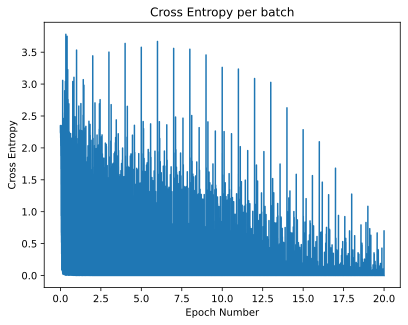

In [89]:
plt.plot(epoch_data, loss_data)
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy per batch')

This appears very noisy, but remember we're using a batch size of 5, so the loss is computed on 12000 samples per epoch, which is a lot.

A smarter way to plot the loss function would be to average the loss over the batches, and plot the average loss for each epoch. Since there are 20 epochs, we can split the array above into 20 equally spaced postions, and average the loss over each of these positions.

In [91]:
epoch_data.shape, loss_data.shape

((240000,), (240000,))

In [97]:
epoch_data.reshape(20, 12000).shape, loss_data.reshape(20, -1).shape # remember that you can explicitly use the last element, 
# but if unknown you can index it with -1

((20, 12000), (20, 12000))

In [93]:
epoch_data_avgd = epoch_data.reshape(20, -1).mean(axis=1)
loss_data_avgd = loss_data.reshape(20, -1).mean(axis=1)

epoch_data_avgd.shape, loss_data_avgd.shape

((20,), (20,))

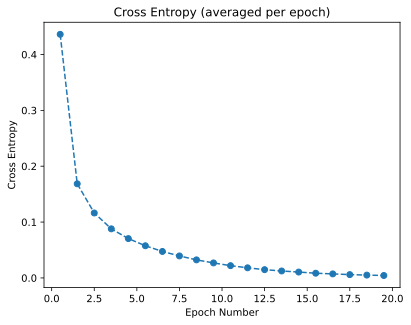

In [101]:
plt.plot(epoch_data_avgd, loss_data_avgd, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (averaged per epoch)')
plt.show()

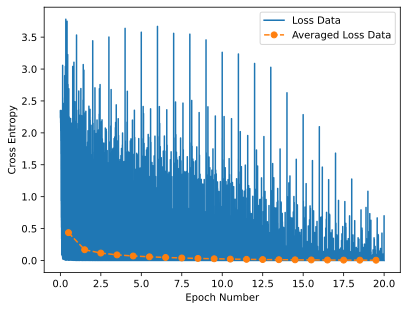

In [99]:
plt.plot(epoch_data, loss_data)
plt.plot(epoch_data_avgd, loss_data_avgd, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.legend(['Loss Data', 'Averaged Loss Data'])
plt.show()

Notice how the averaged loss function rapidly decreases, and then stabilizes close to 0. Let's take a look at a sample image and its prediction.

In [102]:
y_sample = training_ds[0][1]
y_sample

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=torch.float64)

In [104]:
x_sample = training_ds[0][0]
yhat_sample = fun(x_sample, 28, 28)
yhat_sample

tensor([-11.8752,   3.4211,  -1.5402,  24.5541, -21.3175,  26.9769, -14.0665,
         -4.3480,  -6.9417,   6.0648], grad_fn=<SqueezeBackward0>)

Remember that these values are not normalized, but that's not the point here, as the cross entropy loss function takes care of that. 

We need to focus on the maximum value of the prediction, which is the predicted class (larger number means higher probability of being the correct class).

In [106]:
torch.argmax(yhat_sample), torch.argmax(y_sample)

(tensor(5), tensor(5))

The prediction is correct!

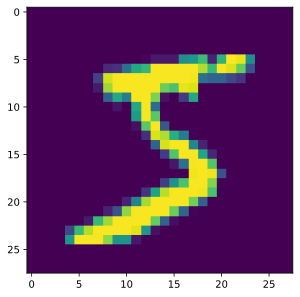

In [107]:
plt.imshow(x_sample)

Let's look at a few more predictions.

In [109]:
fun(xs, 28, 28).shape

torch.Size([2000, 10])

In [108]:
xs, ys = training_ds[0:2000]
yhats = fun(xs, 28, 28).argmax(axis=1)

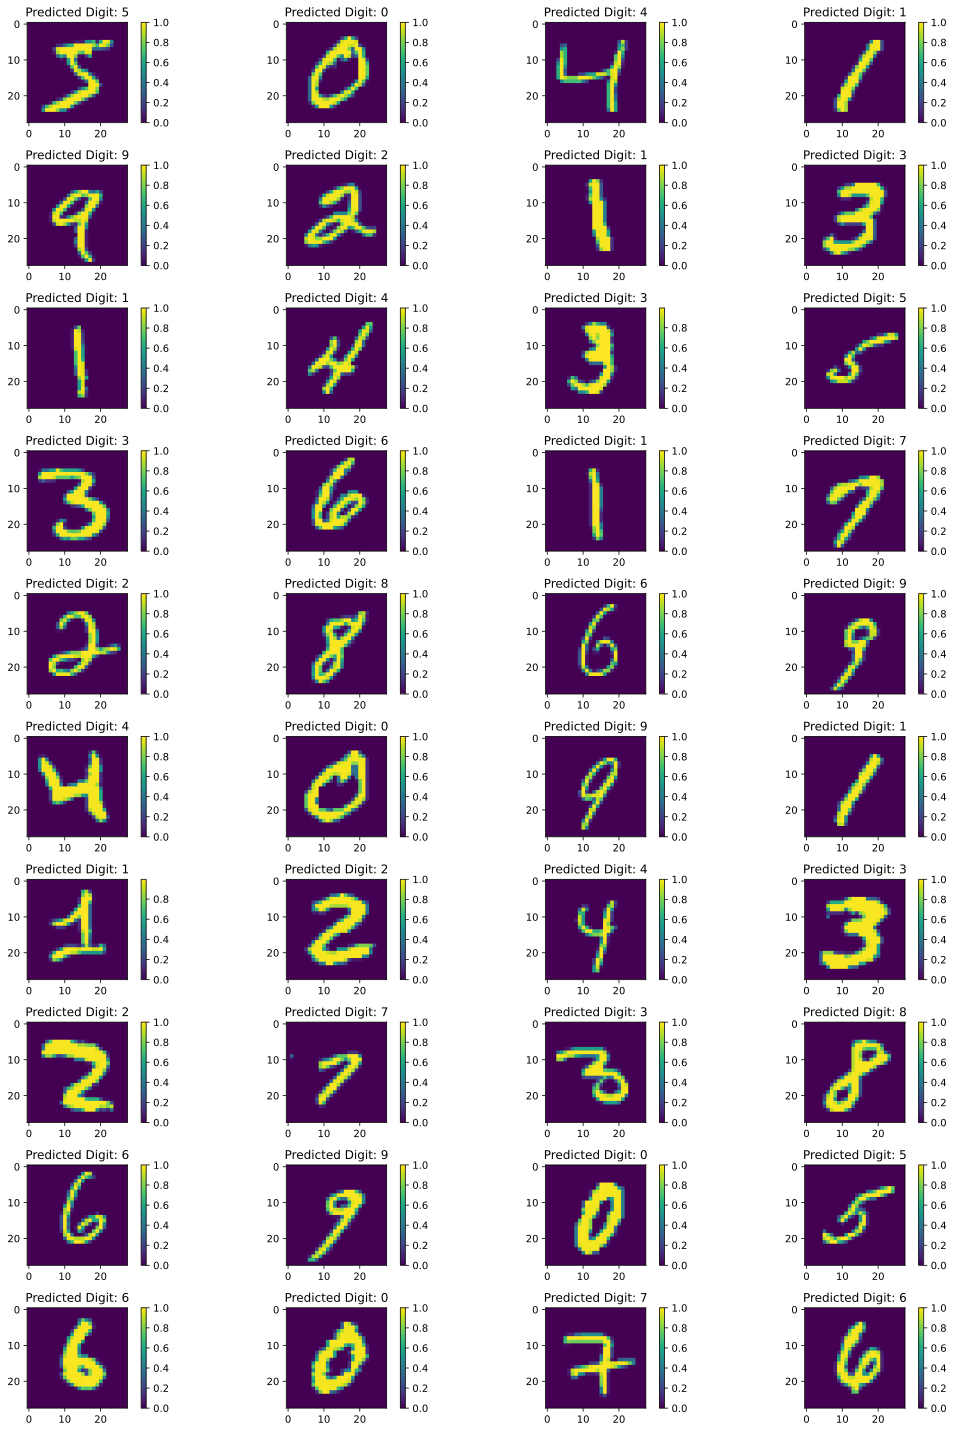

In [115]:
fig, ax = plt.subplots(10, 4, figsize = (15, 20))
for i in range(40): 
    plt.subplot(10, 4, i+1)
    plt.imshow(xs[i])
    plt.colorbar()
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()

The predictions are correct, but this is not surprising as it's a training set. We need to test the model on a test set to see how well it generalizes.

In [116]:
test_dl = DataLoader(test_ds, batch_size=10)

In [121]:
len(test_dl)

1000

In [122]:
epoch_data, loss_data = train_model(test_dl, fun, n_epochs=20, learning_rate=0.01)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Text(0.5, 1.0, 'Cross Entropy per batch')

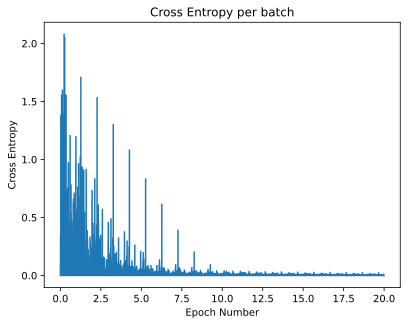

In [124]:
plt.plot(epoch_data, loss_data)
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy per batch')

In [123]:
epoch_data_avgd = epoch_data.reshape(20, -1).mean(axis=1)
loss_data_avgd = loss_data.reshape(20, -1).mean(axis=1)

epoch_data_avgd.shape, loss_data_avgd.shape

((20,), (20,))

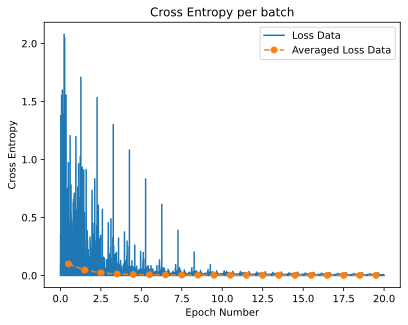

In [126]:
plt.plot(epoch_data, loss_data)
plt.plot(epoch_data_avgd, loss_data_avgd, '--o')
plt.legend(['Loss Data', 'Averaged Loss Data'])
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy per batch')
plt.show()

In [130]:
xt, yt = test_ds[0:1000]
yhats = fun(xt, 28, 28).argmax(axis=1)

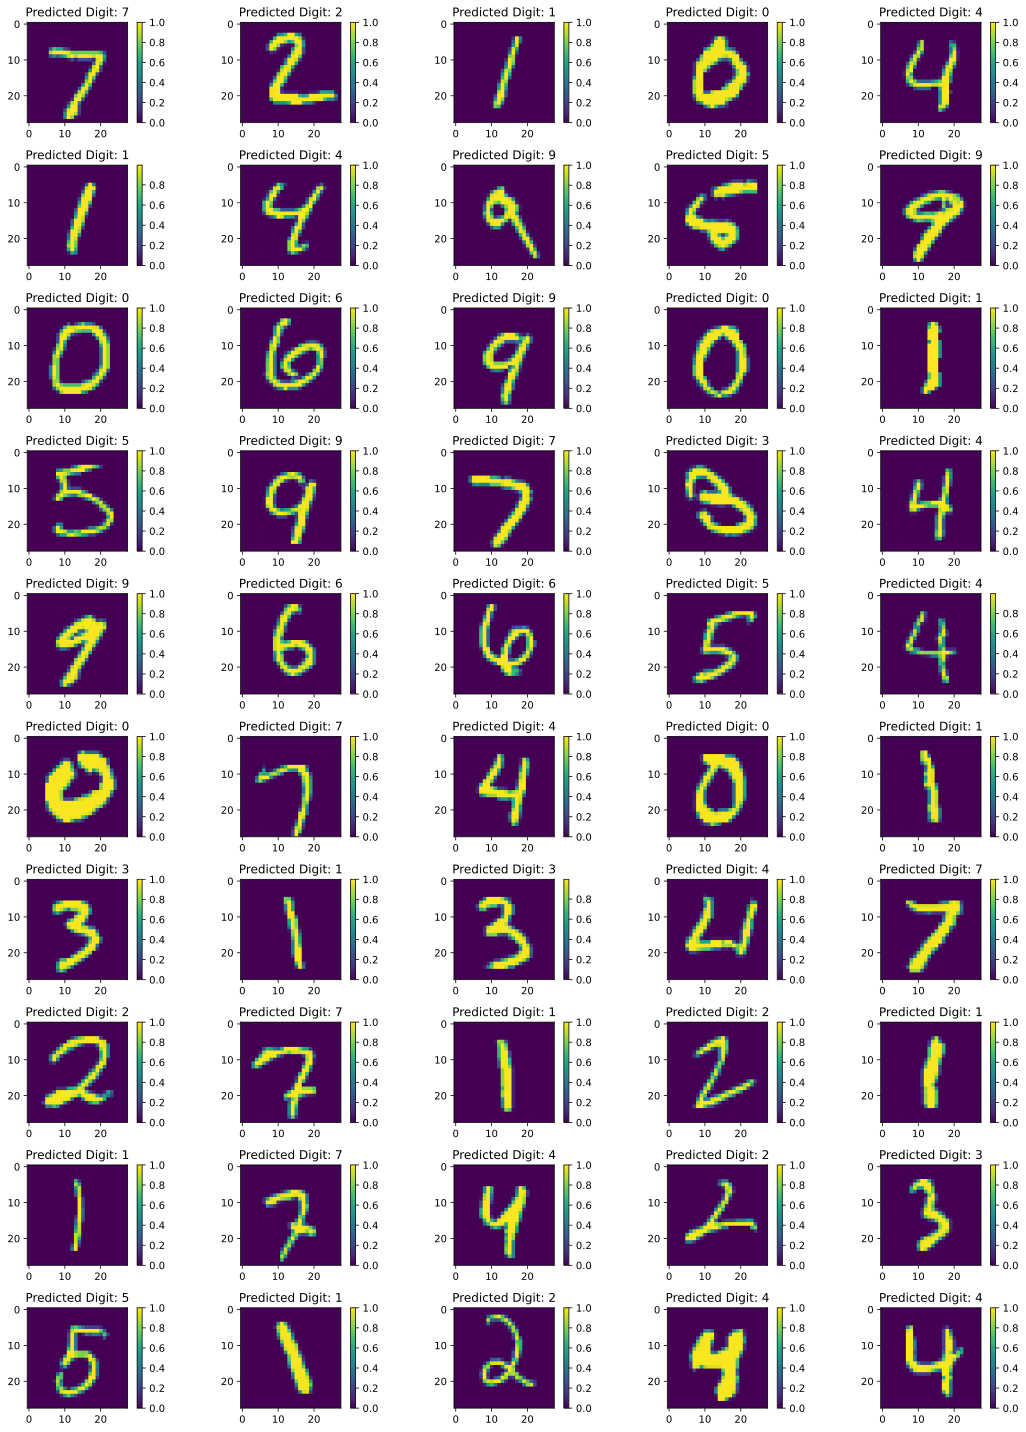

In [133]:
fig, ax = plt.subplots(10, 4, figsize = (15, 20))
for i in range(50): 
    plt.subplot(10, 5, i+1)
    plt.imshow(xt[i])
    plt.colorbar()
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()